In [1]:
pip install pandas numpy matplotlib openpyxl

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Import library yang diperlukan
# Catatan: pandas dan openpyxl HANYA digunakan untuk membaca/menulis Excel
# Semua proses fuzzy logic diimplementasikan dari awal tanpa library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print("✓ Library berhasil diimport")


✓ Library berhasil diimport


In [3]:
class FuzzyCreditRiskSystem:
    """
    Kelas utama untuk sistem penilaian risiko kredit berbasis fuzzy logic
    """
    
    def __init__(self):
        """
        Inisialisasi sistem fuzzy dengan mendefinisikan:
        - Fungsi keanggotaan untuk input (Gaji dan Persentase Cicilan)
        - Fungsi keanggotaan untuk output (Skor Risiko)
        - Aturan inferensi
        """
        # Definisi fungsi keanggotaan untuk Gaji (dalam juta)
        # Range: 1.2 - 25.0 juta
        self.salary_membership = {
            'Low': {'a': 0, 'b': 4, 'c': 8},      # Triangular: Low (0-8 juta)
            'Medium': {'a': 5, 'b': 10, 'c': 15}, # Triangular: Medium (5-15 juta)
            'High': {'a': 12, 'b': 18.5, 'c': 25} # Triangular: High (12-25 juta)
        }
        
        # Definisi fungsi keanggotaan untuk Persentase Cicilan (%)
        # Range: 5% - 62%
        self.installment_membership = {
            'Low': {'a': 0, 'b': 12.5, 'c': 25},   # Triangular: Low (0-25%)
            'Medium': {'a': 15, 'b': 30, 'c': 45}, # Triangular: Medium (15-45%)
            'High': {'a': 35, 'b': 50, 'c': 65}    # Triangular: High (35-65%)
        }
        
        # Definisi fungsi keanggotaan untuk Output Skor Risiko (0-100)
        # Semakin rendah skor, semakin rendah risiko
        self.risk_membership = {
            'VeryLow': {'a': 0, 'b': 10, 'c': 20},     # Triangular: Very Low (0-20)
            'Low': {'a': 10, 'b': 25, 'c': 40},        # Triangular: Low (10-40)
            'Medium': {'a': 30, 'b': 50, 'c': 70},     # Triangular: Medium (30-70)
            'High': {'a': 60, 'b': 75, 'c': 90},       # Triangular: High (60-90)
            'VeryHigh': {'a': 80, 'b': 90, 'c': 100}   # Triangular: Very High (80-100)
        }
        
        # Aturan Inferensi (9 aturan)
        # Format: (Salary, Installment) -> Risk
        self.inference_rules = [
            ('Low', 'Low', 'Medium'),
            ('Low', 'Medium', 'High'),
            ('Low', 'High', 'VeryHigh'),
            ('Medium', 'Low', 'Low'),
            ('Medium', 'Medium', 'Medium'),
            ('Medium', 'High', 'High'),
            ('High', 'Low', 'VeryLow'),
            ('High', 'Medium', 'Low'),
            ('High', 'High', 'Medium')
        ]
    
    def triangular_membership(self, x, a, b, c):
        """
        Menghitung derajat keanggotaan menggunakan fungsi triangular
        
        Parameters:
        x: nilai input
        a: titik awal (derajat keanggotaan = 0)
        b: titik puncak (derajat keanggotaan = 1)
        c: titik akhir (derajat keanggotaan = 0)
        
        Returns:
        Derajat keanggotaan (0-1)
        """
        if x <= a or x >= c:
            return 0.0
        elif a < x <= b:
            if b == a:
                return 1.0
            return (x - a) / (b - a)
        elif b < x < c:
            if c == b:
                return 1.0
            return (c - x) / (c - b)
        else:
            return 0.0
    
    def fuzzification(self, salary, installment_percent):
        """
        Proses fuzzification: mengubah nilai crisp menjadi derajat keanggotaan
        
        Parameters:
        salary: gaji dalam juta
        installment_percent: persentase cicilan terhadap gaji
        
        Returns:
        Dictionary berisi derajat keanggotaan untuk setiap variabel linguistik
        """
        # Fuzzification untuk Gaji
        salary_fuzzy = {}
        for label, params in self.salary_membership.items():
            membership = self.triangular_membership(
                salary, 
                params['a'], 
                params['b'], 
                params['c']
            )
            salary_fuzzy[label] = membership
        
        # Fuzzification untuk Persentase Cicilan
        installment_fuzzy = {}
        for label, params in self.installment_membership.items():
            membership = self.triangular_membership(
                installment_percent,
                params['a'],
                params['b'],
                params['c']
            )
            installment_fuzzy[label] = membership
        
        return salary_fuzzy, installment_fuzzy
    
    def inference(self, salary_fuzzy, installment_fuzzy):
        """
        Proses inferensi: menerapkan aturan fuzzy menggunakan metode MIN (AND)
        dan MAX (OR) untuk agregasi
        
        Parameters:
        salary_fuzzy: dictionary derajat keanggotaan gaji
        installment_fuzzy: dictionary derajat keanggotaan persentase cicilan
        
        Returns:
        Dictionary berisi derajat keanggotaan output untuk setiap risiko
        """
        # Inisialisasi output fuzzy
        risk_fuzzy = {
            'VeryLow': 0.0,
            'Low': 0.0,
            'Medium': 0.0,
            'High': 0.0,
            'VeryHigh': 0.0
        }
        
        # Menerapkan setiap aturan inferensi
        for salary_label, installment_label, risk_label in self.inference_rules:
            # Menggunakan MIN untuk operasi AND (mengambil nilai minimum)
            rule_strength = min(
                salary_fuzzy[salary_label],
                installment_fuzzy[installment_label]
            )
            
            # Menggunakan MAX untuk agregasi (mengambil nilai maksimum)
            risk_fuzzy[risk_label] = max(risk_fuzzy[risk_label], rule_strength)
        
        return risk_fuzzy
    
    def defuzzification_centroid(self, risk_fuzzy):
        """
        Proses defuzzification menggunakan metode Centroid (Center of Gravity)
        
        Parameters:
        risk_fuzzy: dictionary derajat keanggotaan output
        
        Returns:
        Skor risiko kredit (nilai crisp 0-100)
        """
        # Membagi domain output menjadi 1000 titik untuk akurasi
        num_points = 1000
        domain = [i * 100.0 / num_points for i in range(num_points + 1)]
        
        numerator = 0.0
        denominator = 0.0
        
        # Menghitung centroid
        for x in domain:
            # Menghitung derajat keanggotaan output pada titik x
            membership_value = 0.0
            
            for risk_label, membership_degree in risk_fuzzy.items():
                if membership_degree > 0:
                    params = self.risk_membership[risk_label]
                    # Menggunakan MIN untuk clipping (mengambil minimum antara
                    # derajat keanggotaan dari aturan dan fungsi keanggotaan)
                    membership_at_x = min(
                        membership_degree,
                        self.triangular_membership(x, params['a'], params['b'], params['c'])
                    )
                    membership_value = max(membership_value, membership_at_x)
            
            numerator += x * membership_value
            denominator += membership_value
        
        # Menghindari pembagian dengan nol
        if denominator == 0:
            return 50.0  # Nilai default jika tidak ada aktivasi
        
        return numerator / denominator
    
    def calculate_risk_score(self, salary, installment_percent):
        """
        Menghitung skor risiko kredit untuk satu pengaju pinjaman
        
        Parameters:
        salary: gaji dalam juta
        installment_percent: persentase cicilan terhadap gaji
        
        Returns:
        Skor risiko kredit (0-100, semakin rendah semakin baik)
        """
        # Fuzzification
        salary_fuzzy, installment_fuzzy = self.fuzzification(salary, installment_percent)
        
        # Inference
        risk_fuzzy = self.inference(salary_fuzzy, installment_fuzzy)
        
        # Defuzzification
        risk_score = self.defuzzification_centroid(risk_fuzzy)
        
        return risk_score

print("✓ Kelas FuzzyCreditRiskSystem berhasil didefinisikan")


✓ Kelas FuzzyCreditRiskSystem berhasil didefinisikan


In [4]:
# Memperbaiki fungsi read_excel_data untuk menangani header dengan benar
def read_excel_data(filename):
    try:
        # Membaca file Excel (pandas otomatis menggunakan baris pertama sebagai header)
        df = pd.read_excel(filename)
        
        # Mengambil nama kolom
        columns = df.columns.tolist()
        
        print(f"   Kolom yang ditemukan: {columns}")
        print(f"   Jumlah baris data: {len(df)}")
        
        # Mengkonversi ke list of dictionaries
        applicants = []
        for index, row in df.iterrows():
            try:
                # Mengkonversi nilai dengan pengecekan tipe data
                id_value = row[columns[0]]
                salary_value = row[columns[1]]
                installment_value = row[columns[2]]
                
                # Skip jika nilai adalah string yang bukan angka (kemungkinan header atau data invalid)
                if isinstance(id_value, str):
                    # Coba konversi ke float dulu untuk mengecek apakah bisa dikonversi
                    try:
                        float(id_value)
                    except ValueError:
                        # Jika tidak bisa dikonversi, skip baris ini
                        continue
                
                applicant = {
                    'id': int(float(id_value)),  # No Id pengaju pinjama
                    'salary': float(salary_value),  # Gaji (juta)
                    'installment_percent': float(installment_value)  # Persentase cicilan
                }
                applicants.append(applicant)
            except (ValueError, TypeError) as e:
                # Skip baris yang tidak valid
                print(f"   Peringatan: Baris {index + 2} dilewati karena error: {e}")
                continue
        
        if len(applicants) == 0:
            print("   Error: Tidak ada data yang valid ditemukan")
            return None
        
        return applicants
    except FileNotFoundError:
        print(f"Error: File '{filename}' tidak ditemukan!")
        print("   Pastikan file berada di folder yang sama dengan notebook ini.")
        return None
    except Exception as e:
        print(f"Error membaca file Excel: {e}")
        import traceback
        traceback.print_exc()
        return None

print("✓ Fungsi read_excel_data telah diperbaiki")


✓ Fungsi read_excel_data telah diperbaiki


In [5]:
# Helper I/O: baca dan simpan Excel

def read_excel_data(filename):
    try:
        df = pd.read_excel(filename)
        columns = df.columns.tolist()
        applicants = []
        for idx, row in df.iterrows():
            try:
                id_val = row[columns[0]]
                sal = row[columns[1]]
                inst = row[columns[2]]
                if isinstance(id_val, str):
                    try:
                        float(id_val)
                    except ValueError:
                        continue
                applicants.append({
                    'id': int(float(id_val)),
                    'salary': float(sal),
                    'installment_percent': float(inst)
                })
            except (ValueError, TypeError):
                continue
        if len(applicants) == 0:
            print("   Error: Tidak ada data valid")
            return None
        return applicants
    except FileNotFoundError:
        print(f"Error: File '{filename}' tidak ditemukan")
        return None
    except Exception as e:
        print(f"Error membaca file Excel: {e}")
        return None


def save_to_excel(data, filename):
    try:
        pd.DataFrame(data).to_excel(filename, index=False, engine='openpyxl')
        return True
    except Exception as e:
        print(f"Error menyimpan file Excel: {e}")
        return False

print("✓ Helper I/O siap dipakai")


✓ Helper I/O siap dipakai


In [20]:
# Membaca data dari file Excel
input_filename = "resiko kredit.xlsx"
print(f"1. Membaca data dari file: {input_filename}")
applicants = read_excel_data(input_filename)

if applicants is None:
    print("Gagal membaca data. Program dihentikan.")
else:
    print(f"   ✓ Berhasil membaca {len(applicants)} data pengaju pinjaman")
    print(f"\n   Preview data (5 pertama):")
    for i, app in enumerate(applicants[:5], 1):
        print(f"   {i}. ID: {app['id']}, Gaji: {app['salary']} juta, Cicilan: {app['installment_percent']}%")


1. Membaca data dari file: resiko kredit.xlsx
Error: File 'resiko kredit.xlsx' tidak ditemukan
Gagal membaca data. Program dihentikan.


In [7]:
# Inisialisasi sistem fuzzy
print("2. Inisialisasi sistem fuzzy logic...")
fuzzy_system = FuzzyCreditRiskSystem()
print("   ✓ Sistem fuzzy logic siap digunakan")


2. Inisialisasi sistem fuzzy logic...
   ✓ Sistem fuzzy logic siap digunakan


In [8]:
# Menghitung skor risiko untuk setiap pengaju
print("3. Menghitung skor risiko kredit untuk setiap pengaju...")

# Cek apakah data berhasil dibaca
if applicants is None or len(applicants) == 0:
    print("   ✗ Error: Tidak ada data yang dapat diproses. Pastikan file Excel berhasil dibaca.")
    results = []
else:
    results = []
    
    for applicant in applicants:
        risk_score = fuzzy_system.calculate_risk_score(
            applicant['salary'],
            applicant['installment_percent']
        )
        
        results.append({
            'No Id pengaju pinjama': applicant['id'],
            'Gaji (juta)': applicant['salary'],
            'Persentase cicilan pinjaman terhadap gaji(%)': applicant['installment_percent'],
            'Skor Risiko Kredit': round(risk_score, 2)
        })
    
    print(f"   ✓ Selesai menghitung {len(results)} skor risiko")


3. Menghitung skor risiko kredit untuk setiap pengaju...
   ✗ Error: Tidak ada data yang dapat diproses. Pastikan file Excel berhasil dibaca.


In [9]:
# Mengurutkan berdasarkan skor risiko (terkecil = terbaik)
print("4. Mengurutkan berdasarkan skor risiko (terkecil = terbaik)...")

if len(results) == 0:
    print("   ✗ Error: Tidak ada hasil yang dapat diurutkan.")
    results_sorted = []
    top_10 = []
else:
    results_sorted = sorted(results, key=lambda x: x['Skor Risiko Kredit'])
    
    # Mengambil 10 terbaik
    top_10 = results_sorted[:10]
    print("   ✓ 10 pengaju dengan risiko terkecil telah dipilih")


4. Mengurutkan berdasarkan skor risiko (terkecil = terbaik)...
   ✗ Error: Tidak ada hasil yang dapat diurutkan.


In [10]:
# Menampilkan hasil dalam bentuk tabel
if len(top_10) == 0:
    print("Tidak ada data untuk ditampilkan.")
else:
    df_results = pd.DataFrame(top_10)
    print("=" * 80)
    print("10 PENGAJU PINJAMAN DENGAN RISIKO KREDIT TERKECIL")
    print("=" * 80)
    print(df_results.to_string(index=False))
    print("=" * 80)


Tidak ada data untuk ditampilkan.


In [11]:
# Menyimpan hasil ke file Excel
output_filename = "peringkat.xlsx"
print(f"\n5. Menyimpan hasil ke file: {output_filename}")

if len(top_10) == 0:
    print("   ✗ Tidak ada data untuk disimpan.")
elif save_to_excel(top_10, output_filename):
    print(f"   ✓ Berhasil menyimpan {len(top_10)} data ke {output_filename}")
else:
    print(f"   ✗ Gagal menyimpan file")



5. Menyimpan hasil ke file: peringkat.xlsx
   ✗ Tidak ada data untuk disimpan.


In [12]:
# Visualisasi 1: Distribusi Skor Risiko untuk Top 10
if len(top_10) > 0 and len(results) > 0:
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    risk_scores = [r['Skor Risiko Kredit'] for r in top_10]
    ids = [r['No Id pengaju pinjama'] for r in top_10]
    plt.bar(range(len(ids)), risk_scores, color='green', alpha=0.7)
    plt.xlabel('Peringkat')
    plt.ylabel('Skor Risiko Kredit')
    plt.title('Distribusi Skor Risiko untuk Top 10')
    plt.xticks(range(len(ids)), ids, rotation=45)
    plt.grid(axis='y', alpha=0.3)

    # Visualisasi 2: Scatter Plot Gaji vs Cicilan dengan warna berdasarkan risiko
    plt.subplot(1, 2, 2)
    all_salaries = [r['Gaji (juta)'] for r in results]
    all_installments = [r['Persentase cicilan pinjaman terhadap gaji(%)'] for r in results]
    all_risks = [r['Skor Risiko Kredit'] for r in results]

    scatter = plt.scatter(all_salaries, all_installments, c=all_risks, 
                         cmap='RdYlGn_r', alpha=0.6, s=50)
    plt.colorbar(scatter, label='Skor Risiko Kredit')
    plt.xlabel('Gaji (juta)')
    plt.ylabel('Persentase Cicilan (%)')
    plt.title('Hubungan Gaji, Cicilan, dan Risiko Kredit')
    plt.grid(alpha=0.3)

    # Highlight top 10
    top_salaries = [r['Gaji (juta)'] for r in top_10]
    top_installments = [r['Persentase cicilan pinjaman terhadap gaji(%)'] for r in top_10]
    plt.scatter(top_salaries, top_installments, c='blue', marker='*', 
               s=200, edgecolors='black', linewidths=1.5, label='Top 10')
    plt.legend()

    plt.tight_layout()
    plt.show()

    print("✓ Visualisasi selesai")
else:
    print("Tidak ada data untuk divisualisasikan.")


Tidak ada data untuk divisualisasikan.


In [13]:
# Contoh: Analisis detail untuk pengaju dengan ID tertentu
if applicants is None or len(applicants) == 0:
    print("Tidak ada data untuk dianalisis.")
else:
    example_id = 20
    example_app = next((a for a in applicants if a['id'] == example_id), None)

    if example_app:
        print(f"Analisis Detail untuk Pengaju ID {example_id}")
        print("=" * 60)
        print(f"Gaji: {example_app['salary']} juta")
        print(f"Persentase Cicilan: {example_app['installment_percent']}%")
        print()
        
        # Fuzzification
        salary_fuzzy, installment_fuzzy = fuzzy_system.fuzzification(
            example_app['salary'],
            example_app['installment_percent']
        )
        
        print("1. FUZZIFICATION:")
        print(f"   Derajat Keanggotaan Gaji:")
        for label, value in salary_fuzzy.items():
            print(f"      {label}: {value:.4f}")
        print(f"   Derajat Keanggotaan Cicilan:")
        for label, value in installment_fuzzy.items():
            print(f"      {label}: {value:.4f}")
        print()
        
        # Inference
        risk_fuzzy = fuzzy_system.inference(salary_fuzzy, installment_fuzzy)
        print("2. INFERENCE (Aktivasi Aturan):")
        for label, value in risk_fuzzy.items():
            if value > 0:
                print(f"      {label}: {value:.4f}")
        print()
        
        # Defuzzification
        risk_score = fuzzy_system.defuzzification_centroid(risk_fuzzy)
        print(f"3. DEFUZZIFICATION:")
        print(f"   Skor Risiko Kredit: {risk_score:.2f}")
        print("=" * 60)
    else:
        print(f"Pengaju dengan ID {example_id} tidak ditemukan")


Tidak ada data untuk dianalisis.


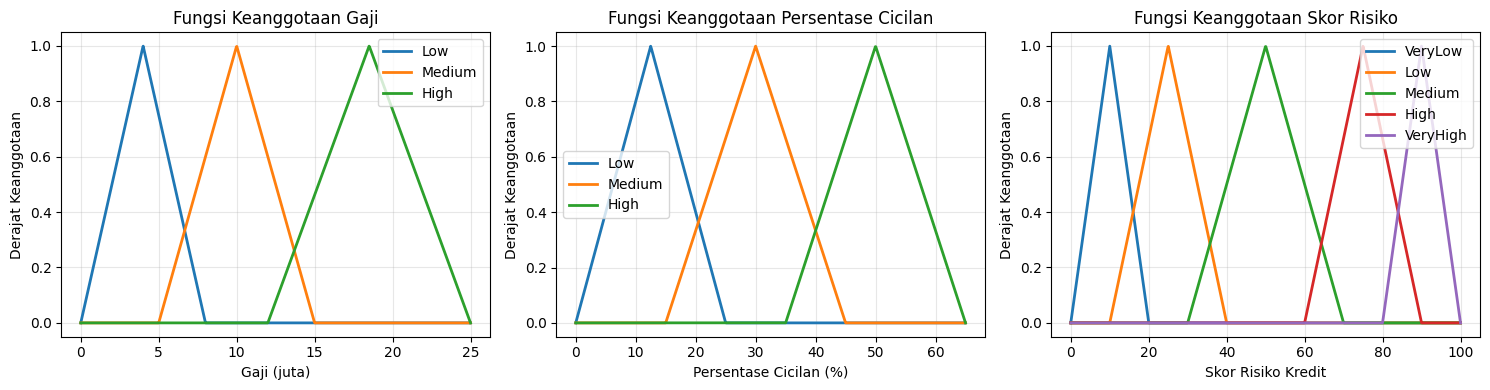

✓ Visualisasi fungsi keanggotaan selesai


In [14]:
# Visualisasi fungsi keanggotaan
# Visualisasi ini tidak memerlukan data, hanya menampilkan fungsi keanggotaan
try:
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    # Fungsi keanggotaan Gaji
    ax1 = axes[0]
    x_salary = np.linspace(0, 25, 1000)
    for label, params in fuzzy_system.salary_membership.items():
        y = [fuzzy_system.triangular_membership(x, params['a'], params['b'], params['c']) 
             for x in x_salary]
        ax1.plot(x_salary, y, label=label, linewidth=2)
    ax1.set_xlabel('Gaji (juta)')
    ax1.set_ylabel('Derajat Keanggotaan')
    ax1.set_title('Fungsi Keanggotaan Gaji')
    ax1.legend()
    ax1.grid(alpha=0.3)

    # Fungsi keanggotaan Persentase Cicilan
    ax2 = axes[1]
    x_installment = np.linspace(0, 65, 1000)
    for label, params in fuzzy_system.installment_membership.items():
        y = [fuzzy_system.triangular_membership(x, params['a'], params['b'], params['c']) 
             for x in x_installment]
        ax2.plot(x_installment, y, label=label, linewidth=2)
    ax2.set_xlabel('Persentase Cicilan (%)')
    ax2.set_ylabel('Derajat Keanggotaan')
    ax2.set_title('Fungsi Keanggotaan Persentase Cicilan')
    ax2.legend()
    ax2.grid(alpha=0.3)

    # Fungsi keanggotaan Skor Risiko
    ax3 = axes[2]
    x_risk = np.linspace(0, 100, 1000)
    for label, params in fuzzy_system.risk_membership.items():
        y = [fuzzy_system.triangular_membership(x, params['a'], params['b'], params['c']) 
             for x in x_risk]
        ax3.plot(x_risk, y, label=label, linewidth=2)
    ax3.set_xlabel('Skor Risiko Kredit')
    ax3.set_ylabel('Derajat Keanggotaan')
    ax3.set_title('Fungsi Keanggotaan Skor Risiko')
    ax3.legend()
    ax3.grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("✓ Visualisasi fungsi keanggotaan selesai")
except NameError:
    print("Error: Sistem fuzzy belum diinisialisasi. Jalankan cell sebelumnya terlebih dahulu.")
